**MCRB and CRB**

In [172]:
# Libraries
from scipy.stats import t, norm
from scipy.special import gamma
from scipy.optimize import fsolve, minimize_scalar
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [173]:
# Parameters
N = 1000
nb_est = 100
theta = 0.5
sigma = 1
v = 3
mu = sigma*(1-theta**2)

In [174]:
def generate_Normal(theta,N,sigma):
    X_Normal = [np.random.normal(0, 1)]
    epsilon = np.random.normal(0, (1-theta**2)*sigma, size=N)
    for e in epsilon:
        X_Normal.append(theta*X_Normal[-1] + e)
    return np.array(X_Normal), epsilon

X_Normal, epsilon_normal = generate_Normal(theta,N,sigma)

In [175]:
def generate_Student(theta,N,mu,v):
    X_Student = [np.random.normal(0, 1)]
    epsilon = 1/mu * t.rvs(df=v, size=N)
    for e in epsilon:
        X_Student.append(theta*X_Student[-1] + e)
    return np.array(X_Student), epsilon

X_Student, epsilon_student = generate_Student(theta,N,sigma,v)

**1st case:** t-distribution misspecified as Gaussian

In [176]:
def compute_MCRB(theta,N):
    return (1-theta**2)/N

print("MCRB:",compute_MCRB(theta,N))

MCRB: 0.00075


**2nd case:** t-distribution correctly specified

In [177]:
def compute_CRB_numeric(theta,N,mu,v,x_range=np.linspace(-100, 100, 10000)):
    const = gamma((v + 1) / 2) / (np.sqrt(v * np.pi / mu) * gamma(v / 2))
    f_t = const * (1 + x_range**2 / (v / mu)) ** (-(v + 1) / 2)

    f_int = ((x_range**2 - (v / mu)) / (v / mu + x_range**2)**2) * f_t
    g = np.trapz(f_int, x_range)

    crb_t = - (1 - theta**2) / N * ((v - 2) * mu) / (v * (v + 1) * g)
    return crb_t

print("CRB:", compute_CRB_numeric(theta, N, sigma,v))

CRB: 0.0003749999997026011


In [178]:
def compute_CRB(theta,N,v):
    return (v - 2) * (1 - theta**2) * (v + 3) / (N * v * (v + 1))

print("CRB:",compute_CRB(theta,N,v))

CRB: 0.000375


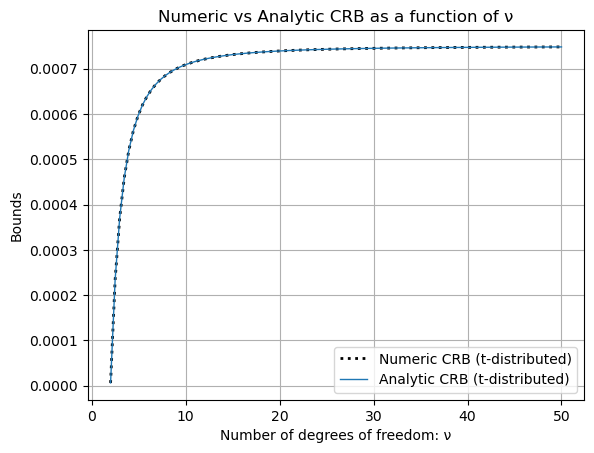

In [179]:
# Let's check if both CRB are the same
list_v = np.linspace(2.01,50,100)
list_CRB_numeric = [compute_CRB_numeric(theta,N,mu,v) for v in list_v]
list_CRB= [compute_CRB(theta,N,v) for v in list_v]

plt.plot(list_v, list_CRB_numeric, ':k', label='Numeric CRB (t-distributed)', linewidth=2)
plt.plot(list_v,list_CRB,label='Analytic CRB (t-distributed)',linewidth=1)
plt.xlabel("Number of degrees of freedom: ν")
plt.ylabel("Bounds")
plt.title("Numeric vs Analytic CRB as a function of ν")
plt.legend()
plt.grid(True)
plt.show()

**Comparison**

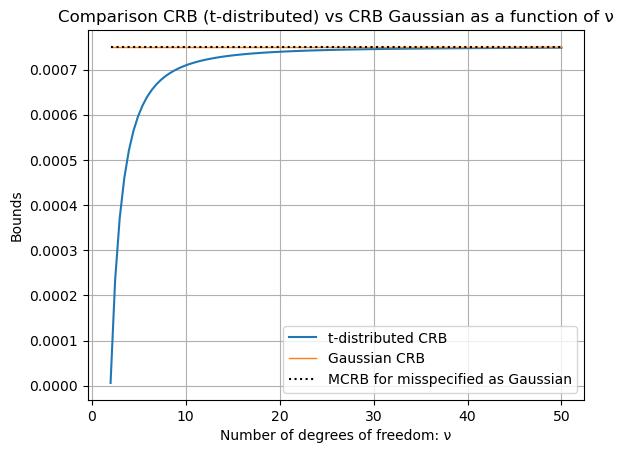

In [180]:
#Visualization
list_v = np.linspace(2.01,50,100)
list_MCRB= [compute_MCRB(theta,N) for v in list_v]
list_CRB= [compute_CRB(theta,N,v) for v in list_v]

plt.plot(list_v, list_CRB, label='t-distributed CRB', linewidth=1.5)
plt.plot(list_v,[(1 - theta**2)/N] * len(list_v),label='Gaussian CRB',linewidth=1)
plt.plot(list_v, list_MCRB,":k", label='MCRB for misspecified as Gaussian', linewidth=1.5)

plt.xlabel("Number of degrees of freedom: ν")
plt.ylabel("Bounds")
plt.title("Comparison CRB (t-distributed) vs CRB Gaussian as a function of ν")
plt.legend()
plt.grid(True)
plt.show()


**Estimation of θ**

Maximum Likelihood Estimator (MLE)

In [10]:
# Compute the estimators
def theta_ml_est(X):
    N = len(X) - 1
    num = np.sum([X[i] * X[i + 1] for i in range(N)])
    denom = np.sum([X[i]**2 for i in range(N)])
    return num / denom

theta_ml = theta_ml_est(X_Student)
print("Maximum likelihood estimation of θ: ",theta_ml)

Maximum likelihood estimation of θ:  0.4858491743477736


Newton method estimator

In [11]:
def log_likelihood_gradient(X,theta,mu,v):
    N = len(X) - 1
    grad = 0
    for i in range(N):
        Xi, Xi1 = X[i], X[i+1]
        z = Xi1 - theta * Xi
        denom = 1 + (mu / v) * z**2
        grad += Xi * z / denom
    return (v + 1) * mu / v * grad

def log_likelihood_hessian(X,theta,mu,v):
    N = len(X) - 1
    hess = 0
    for i in range(N):
        Xi, Xi1 = X[i], X[i+1]
        z = Xi1 - theta * Xi
        num = 1 - (mu / v) * z**2
        denom = (1 + (mu / v) * z**2)**2
        hess += Xi**2 * num / denom
    return - (v + 1) * mu / v * hess

def theta_newton_est(X,theta,N,mu,v,tol=1e-10,max_iter=1000):
     sigma2 = np.var([X[i+1] - theta * X[i] for i in range(N)], ddof=1)
     theta_list = [theta]
     for _ in range(max_iter):
        grad = log_likelihood_gradient(X, theta_list[-1], mu,v)
        hess = log_likelihood_hessian(X, theta_list[-1], mu,v)
        
        if abs(hess) < 1e-10:
            break
        
        theta_new = theta_list[-1] - grad / hess
        if abs(theta_new - theta_list[-1]) < tol:
            return theta_new
        theta_list.append(theta_new)

     return theta_list[-1]

theta_newton = theta_newton_est(X_Student,theta_ml,N,mu,v)
print("Newton method estimation of θ: ",theta_newton)

Newton method estimation of θ:  0.497091949398751


M-estimator

In [12]:
def huber(x,c):
    x = np.asarray(x)
    return np.where(np.abs(x) <= c, x, c * np.sign(x))

def tukey(x,c):
    x = np.asarray(x)
    inside = np.abs(x) <= c
    result = np.zeros_like(x)
    result[inside] = x[inside] * (1 - (x[inside])/ c**2)**2
    return result

def system(theta_est,X,c,loss_function):
    N = len(X) - 1
    residuals = X[1:] - theta_est * X[:-1]
    loss_function_vals = loss_function(residuals,c)
    return np.sum(X[:-1] * loss_function_vals)

def m_estimator(X,theta,c,loss_function):
    sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)
    return sol[0]

theta_huber = m_estimator(X_Student,theta_ml,c=1,loss_function=huber)
theta_tukey = m_estimator(X_Student,theta_ml,c=1,loss_function=tukey)
print("M-estimator (Huber):", theta_huber)
print("M-estimator (Tukey):", theta_tukey)


M-estimator (Huber): 0.4947519677209905
M-estimator (Tukey): 0.4890815576826567


**Mean Square Error**

In [13]:
def square_error(theta_est,theta):
    return (theta_est-theta)**2

def mse_newton(theta,N,sigma,v,nb_est):
    theta_newton_list = []
    for _ in range(nb_est):
        mu_loc = sigma*(1-theta**2)
        X, _ = generate_Student(theta,N,sigma,v)
        theta_ml = theta_ml_est(X) 
        theta_est = theta_newton_est(X,theta_ml,N,mu_loc,v)
        theta_newton_list.append(theta_est)
    
    square_error_list_newton = [square_error(theta_est, theta) for theta_est in theta_newton_list]
    mean_square_error_newton = np.mean(square_error_list_newton)
    return mean_square_error_newton

def mse_ml(theta,N,sigma,v,nb_est):
    theta_ml_list = []
    for _ in range(nb_est):
        X, _ = generate_Student(theta,N,sigma,v)
        theta_est = theta_ml_est(X)
        theta_ml_list.append(theta_est)

    square_error_list_ml = [square_error(theta_est,theta) for theta_est in theta_ml_list]
    mean_square_error_ml = np.mean(square_error_list_ml)
    return mean_square_error_ml

def mse_m_estimator(theta,N,sigma,v,c,loss_function,nb_est):
    theta_m_list = []
    for _ in range(nb_est):
        X, _ = generate_Student(theta,N,sigma,v)
        theta_ml = theta_ml_est(X) 
        theta_est = m_estimator(X,theta_ml,c,loss_function)
        theta_m_list.append(theta_est)
    
    square_error_list_m = [square_error(theta_est, theta) for theta_est in theta_m_list]
    mean_square_error_m = np.mean(square_error_list_m)
    return mean_square_error_m


print("MSE(theta_ml) :", mse_ml(theta,N,sigma,v,nb_est))
print("MSE(theta_newton) :", mse_newton(theta,N,sigma,v,nb_est))
print("MSE (theta_huber) :", mse_m_estimator(theta,N,sigma,v,c=1,loss_function=huber,nb_est=100))
print("MSE (theta_tukey) :", mse_m_estimator(theta,N,sigma,v,c=1,loss_function=tukey,nb_est=100))



MSE(theta_ml) : 0.000693786486142003
MSE(theta_newton) : 0.00034643860634398047
MSE (theta_huber) : 0.0004987077961690955


C:\Users\inech\AppData\Local\Temp\ipykernel_74020\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)
C:\Users\inech\AppData\Local\Temp\ipykernel_74020\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


MSE (theta_tukey) : 0.0013876261333381804


In [ ]:
# The influence of the degree of freedom on the value of c and the optimal estimator
v_values = np.linspace(2, 30, 10)
c_values = np.linspace(0.5, 10, 30)

mse_huber = np.zeros((len(v_values), len(c_values)))
mse_tukey = np.zeros((len(v_values), len(c_values)))
best_c_huber = []
best_c_tukey = []

for i, v in enumerate(v_values):
    for j, c in enumerate(c_values):
        mse_huber[i, j] = mse_m_estimator(theta, N, sigma, v, c, huber, nb_est=100)
        mse_tukey[i, j] = mse_m_estimator(theta, N, sigma, v, c, tukey, nb_est=100)

    idx_best_huber = np.argmin(mse_huber[i, :])
    idx_best_tukey = np.argmin(mse_tukey[i, :])
    best_c_huber.append(c_values[idx_best_huber])
    best_c_tukey.append(c_values[idx_best_tukey])

print("v\tBest_c_Huber\tBest_MSE_Huber\tBest_c_Tukey\tBest_MSE_Tukey\tBest_loss_function")
for i, v in enumerate(v_values):
    idx_h = np.argmin(mse_huber[i, :])
    idx_t = np.argmin(mse_tukey[i, :])
    mse_h = mse_huber[i, idx_h]
    mse_t = mse_tukey[i, idx_t]
    best_func = "Huber" if mse_h < mse_t else "Tukey"
    print(f"{v:.2f}\t{c_values[idx_h]:.2f}\t\t{mse_h:.5e}\t{c_values[idx_t]:.2f}\t\t{mse_t:.5e}\t{best_func}")


C:\Users\inech\AppData\Local\Temp\ipykernel_19340\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)
C:\Users\inech\AppData\Local\Temp\ipykernel_19340\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


v	Best_c_Huber	Best_MSE_Huber	Best_c_Tukey	Best_MSE_Tukey	Best_loss_function
2.00	1.48		1.56650e-04	4.10		2.11640e-04	Huber
5.11	2.79		5.20561e-04	5.41		5.76939e-04	Huber
8.22	4.10		5.71587e-04	5.41		5.25755e-04	Tukey
11.33	5.09		5.23194e-04	5.74		5.82993e-04	Huber
14.44	6.40		5.92078e-04	3.78		6.10708e-04	Huber
17.56	3.45		5.41834e-04	3.45		6.15645e-04	Huber
20.67	7.71		6.22499e-04	7.05		6.05514e-04	Tukey
23.78	7.38		5.76527e-04	8.36		5.63391e-04	Tukey
26.89	7.38		5.97005e-04	6.07		5.54447e-04	Tukey
30.00	3.45		6.33283e-04	6.40		5.86395e-04	Tukey


C:\Users\inech\AppData\Local\Temp\ipykernel_19340\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)
C:\Users\inech\AppData\Local\Temp\ipykernel_19340\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


Best c for Huber: 0.798 with MSE = 0.00039
Best c for Tukey: 4.672 with MSE = 0.00053


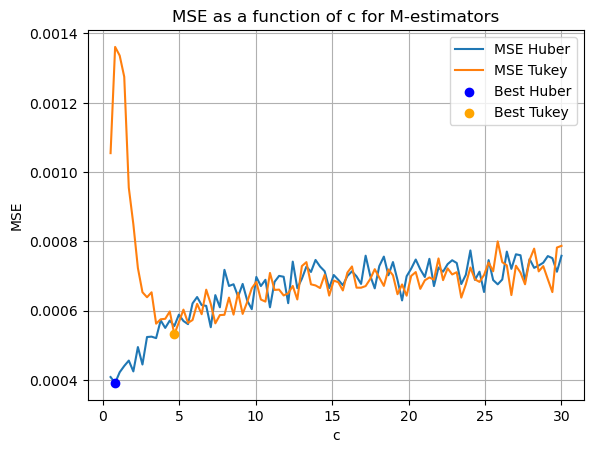

In [73]:
c_values = np.linspace(0.5, 30, 100)
mse_huber_list = []
mse_tukey_list = []

for c in c_values:
    mse_huber_list.append(mse_m_estimator(theta,N,sigma,v,c,huber,nb_est=1000))
    mse_tukey_list.append(mse_m_estimator(theta,N,sigma,v,c,tukey,nb_est=1000))

best_c_huber = c_values[np.argmin(mse_huber_list)]
best_c_tukey = c_values[np.argmin(mse_tukey_list)]

print(f"Best c for Huber: {best_c_huber:.3f} with MSE = {min(mse_huber_list):.5f}")
print(f"Best c for Tukey: {best_c_tukey:.3f} with MSE = {min(mse_tukey_list):.5f}")

plt.plot(c_values, mse_huber_list, label="MSE Huber")
plt.plot(c_values, mse_tukey_list, label="MSE Tukey")
plt.scatter([best_c_huber], [min(mse_huber_list)], color='blue', label='Best Huber', zorder=5)
plt.scatter([best_c_tukey], [min(mse_tukey_list)], color='orange', label='Best Tukey', zorder=5)
plt.xlabel("c")
plt.ylabel("MSE")
plt.title("MSE as a function of c for M-estimators")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# Simulations for N
N = 1000
theta = 0.5
sigma = 1
v = 3
list_N = np.arange(100, 10000, 100)

mean_square_error_list_newton = []
mean_square_error_list_ml = []
mean_square_error_list_m = []

for n in tqdm(list_N):
    mean_square_error_list_newton.append(mse_newton(theta,n,sigma,v,nb_est))
    mean_square_error_list_ml.append(mse_ml(theta,n,sigma,v,nb_est))
    mean_square_error_list_m.append(mse_m_estimator(theta,n,sigma,v,c=0.798,loss_function=huber,nb_est=100))

C:\Users\inech\AppData\Local\Temp\ipykernel_19340\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 

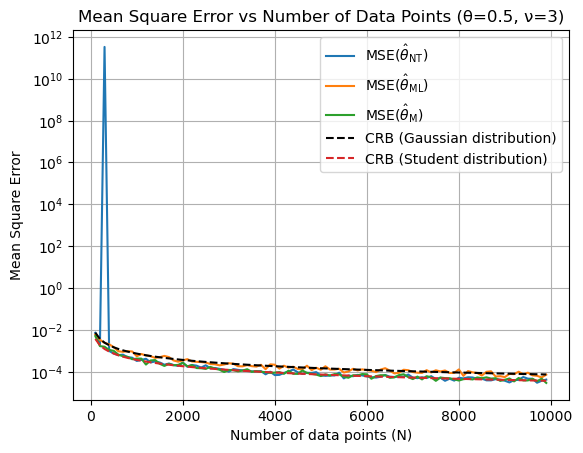

In [ ]:
# Visualization as a function of N
CRB_list_N = [(1-theta**2)/n for n in list_N]
CRB_Student_list_N = [compute_CRB(theta,n,v) for n in list_N ]
plt.plot(list_N, mean_square_error_list_newton, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{NT}})$")
plt.plot(list_N, mean_square_error_list_ml, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{ML}})$")
plt.plot(list_N,mean_square_error_list_m,label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{M}})$")
plt.plot(list_N, CRB_list_N, '--k', label="CRB (Gaussian distribution)") 
plt.plot(list_N, CRB_Student_list_N, '--', label="CRB (t-distribution)") 
plt.xlabel("Number of data points (N)")
plt.ylabel("Mean Square Error")
plt.yscale("log")
plt.title(f"Mean Square Error vs Number of Data Points (θ={theta}, ν={v})")
plt.legend()
plt.grid(True)
plt.show()

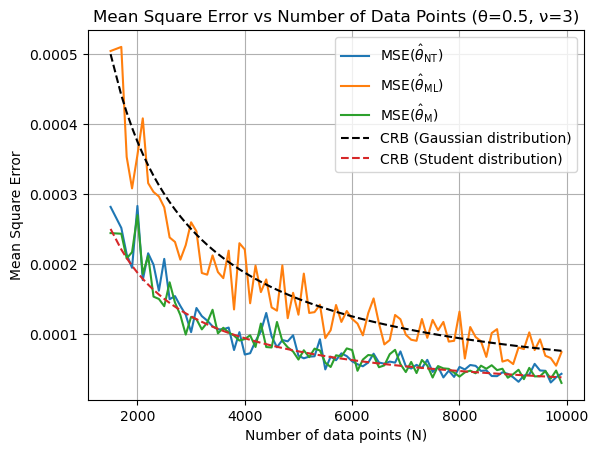

In [ ]:
# Delete the outliers
N_array = np.array(list_N)
mse_newton_array = np.array(mean_square_error_list_newton)
mse_ml_array = np.array(mean_square_error_list_ml)
mse_m_array = np.array(mean_square_error_list_m)

# IQR method to detect the outliers
q1_newton, q3_newton = np.percentile(mse_newton_array, [25, 75])
iqr_newton = q3_newton - q1_newton
mask_newton = (mse_newton_array >= q1_newton - 1.5 * iqr_newton) & (mse_newton_array <= q3_newton + 1.5 * iqr_newton)

q1_ml, q3_ml = np.percentile(mse_ml_array, [25, 75])
iqr_ml = q3_ml - q1_ml
mask_ml = (mse_ml_array >= q1_ml - 1.5 * iqr_ml) & (mse_ml_array <= q3_ml + 1.5 * iqr_ml)

q1_m, q3_m = np.percentile(mse_m_array, [25, 75])
iqr_m = q3_m - q1_m
mask_m = (mse_m_array >= q1_m - 1.5 * iqr_m) & (mse_m_array <= q3_m + 1.5 * iqr_m)

mask = mask_newton & mask_ml & mask_m

# Filtering
N_filtered = N_array[mask]
mse_newton_filtered = mse_newton_array[mask]
mse_ml_filtered = mse_ml_array[mask]
mse_m_filtered = mse_m_array[mask]
CRB_list_filtered = np.array(CRB_list_N)[mask]
CRB_Student_list_filtered = np.array(CRB_Student_list_N)[mask]

# Plot
plt.plot(N_filtered, mse_newton_filtered, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{NT}})$")
plt.plot(N_filtered, mse_ml_filtered, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{ML}})$")
plt.plot(N_filtered, mse_m_filtered, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{M}})$")
plt.plot(N_filtered, CRB_list_filtered, '--k', label="CRB (Gaussian distribution)") 
plt.plot(N_filtered, CRB_Student_list_filtered, '--', label="CRB t(-distribution)") 
plt.xlabel("Number of data points (N)")
plt.ylabel("Mean Square Error")
plt.title(f"Mean Square Error vs Number of Data Points (θ={theta}, ν=3)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Simulations for v
N = 1000
theta = 0.5
sigma = 1
v = 3
list_v = np.arange(2.1, 30, 1)

mean_square_error_list_newton_v = []
mean_square_error_list_ml_v = []
mean_square_error_list_m_v = []
CRB_Student_list_v = [compute_CRB(theta,N,nu) for nu in list_v ]

for nu in tqdm(list_v):
    mean_square_error_list_newton_v.append(mse_newton(theta,N,sigma,nu,nb_est=10000))
    mean_square_error_list_ml_v.append(mse_ml(theta,N,sigma,nu,nb_est=10000))
    mean_square_error_list_m_v.append(mse_m_estimator(theta,N,sigma,nu,c=0.798,loss_function=huber,nb_est=10000))

C:\Users\inech\AppData\Local\Temp\ipykernel_19340\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


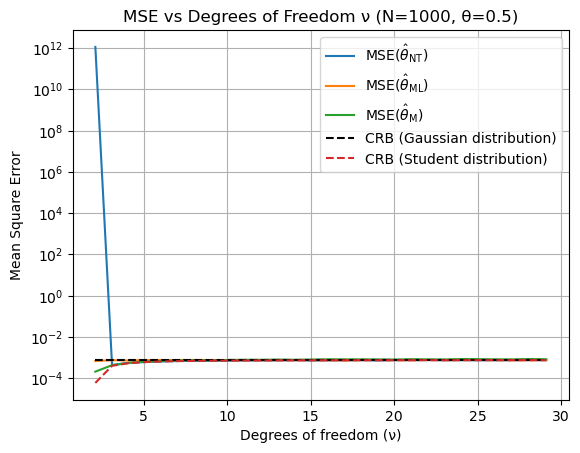

In [ ]:
# Visualization as a function of v
plt.plot(list_v, mean_square_error_list_newton_v, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{NT}})$")
plt.plot(list_v, mean_square_error_list_ml_v, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{ML}})$")
plt.plot(list_v,mean_square_error_list_m_v,label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{M}})$")
plt.plot(list_v, np.full_like(list_v, (1-theta**2)/N), '--k', label="CRB (Gaussian distribution)") 
plt.plot(list_v, CRB_Student_list_v, '--', label="CRB (t-distribution)") 
plt.xlabel("Degrees of freedom (ν)")
plt.ylabel("Mean Square Error")
plt.yscale("log")
plt.title(f"MSE vs Degrees of Freedom ν (N={N}, θ={theta})")
plt.legend()
plt.grid(True)
plt.show()

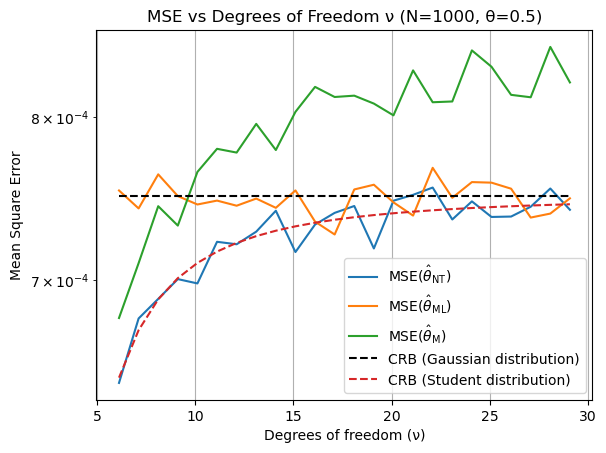

In [ ]:
# Delete the outliers
v_array = np.array(list_v)
mse_newton_array = np.array(mean_square_error_list_newton_v)
mse_ml_array = np.array(mean_square_error_list_ml_v)
mse_m_array = np.array(mean_square_error_list_m_v)
CRB_student_array = np.array(CRB_Student_list_v)

def iqr_mask(arr):
    q1, q3 = np.percentile(arr, [25, 75])
    iqr = q3 - q1
    return (arr >= q1 - 1.5 * iqr) & (arr <= q3 + 1.5 * iqr)

mask_newton = iqr_mask(mse_newton_array)
mask_ml = iqr_mask(mse_ml_array)
mask_m = iqr_mask(mse_m_array)

mask = mask_newton & mask_ml & mask_m

v_filtered = v_array[mask]
mse_newton_filtered = mse_newton_array[mask]
mse_ml_filtered = mse_ml_array[mask]
mse_m_filtered = mse_m_array[mask]
CRB_student_filtered = CRB_student_array[mask]
crb_gaussian_filtered = np.full_like(v_filtered, (1 - theta**2) / N) 

plt.plot(v_filtered, mse_newton_filtered, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{NT}})$")
plt.plot(v_filtered, mse_ml_filtered, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{ML}})$")
plt.plot(v_filtered, mse_m_filtered, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{M}})$")
plt.plot(v_filtered, crb_gaussian_filtered, '--k', label="CRB (Gaussian distribution)")
plt.plot(v_filtered, CRB_student_filtered, '--', label="CRB (t-distribution)")
plt.xlabel("Degrees of freedom (ν)")
plt.ylabel("Mean Square Error")
plt.yscale("log")
plt.title(f"MSE vs Degrees of Freedom ν (N={N}, θ={theta})")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Simulations for θ
N = 1000
theta = 0.5
sigma = 1
v = 3
list_theta = np.arange(0.01, 0.99, 0.01)
CRB_list_theta = [(1-th**2)/N for th in list_theta]
CRB_Student_list_theta = [compute_CRB(th,N,v) for th in list_theta ]

mse_newton_list_t = []
mse_ml_list_t = []
mse_m_list_t = []

for th in tqdm(list_theta):
    mse_newton_list_t.append(mse_newton(th,N,sigma,v,nb_est=100))
    mse_ml_list_t.append(mse_ml(th,N,sigma,v,nb_est=100))
    mse_m_list_t.append(mse_m_estimator(th,N,sigma,v,c=0.798,loss_function=huber,nb_est=100))

C:\Users\inech\AppData\Local\Temp\ipykernel_19340\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


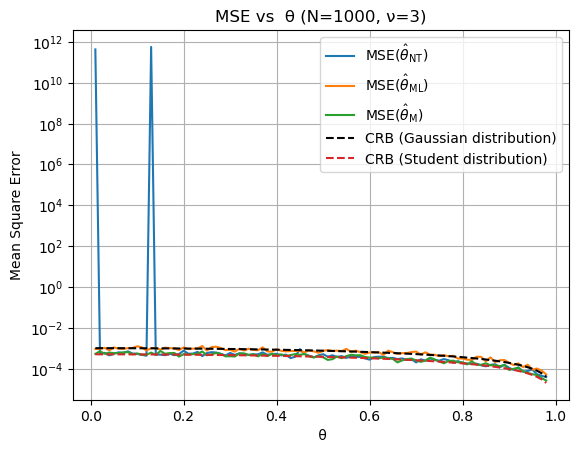

In [ ]:
# Visualization as a function of θ
plt.plot(list_theta, mse_newton_list_t, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{NT}})$")
plt.plot(list_theta, mse_ml_list_t, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{ML}})$")
plt.plot(list_theta,mse_m_list_t,label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{M}})$")
plt.plot(list_theta, CRB_list_theta, '--k', label="CRB (Gaussian distribution)")
plt.plot(list_theta, CRB_Student_list_theta, '--', label="CRB (t-distribution)") 
plt.xlabel(" θ")
plt.yscale("log")
plt.ylabel("Mean Square Error")
plt.title(f"MSE vs  θ (N={N}, ν={v})")
plt.legend()
plt.grid(True)
plt.show()

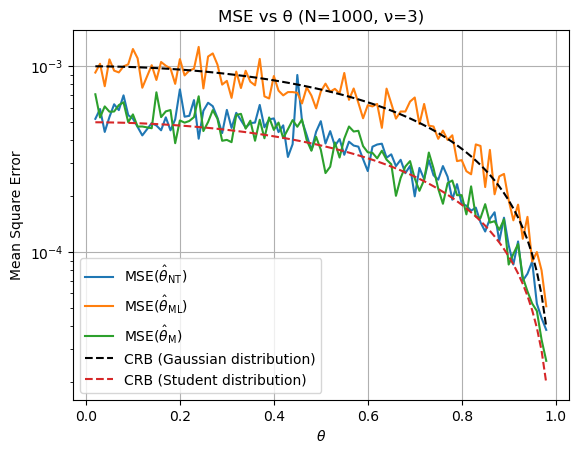

In [ ]:
# Delete the outliers
theta_array = np.array(list_theta)
mse_newton_array_t = np.array(mse_newton_list_t)
mse_ml_array_t = np.array(mse_ml_list_t)
mse_m_array_t = np.array(mse_m_list_t)
crb_gaussian_array = np.array(CRB_list_theta)
crb_student_array = np.array(CRB_Student_list_theta)

q1_newton, q3_newton = np.percentile(mse_newton_array_t, [25, 75])
iqr_newton = q3_newton - q1_newton
mask_newton = (mse_newton_array_t >= q1_newton - 1.5 * iqr_newton) & (mse_newton_array_t <= q3_newton + 1.5 * iqr_newton)
q1_ml, q3_ml = np.percentile(mse_ml_array_t, [25, 75])
iqr_ml = q3_ml - q1_ml
mask_ml = (mse_ml_array_t >= q1_ml - 1.5 * iqr_ml) & (mse_ml_array_t <= q3_ml + 1.5 * iqr_ml)
q1_m, q3_m = np.percentile(mse_m_array_t, [25, 75])
iqr_m = q3_m - q1_m
mask_m = (mse_m_array_t >= q1_m - 1.5 * iqr_m) & (mse_m_array_t <= q3_m + 1.5 * iqr_m)

mask = mask_newton & mask_ml & mask_m

theta_filtered = theta_array[mask]
mse_newton_filtered = mse_newton_array_t[mask]
mse_ml_filtered = mse_ml_array_t[mask]
mse_m_filtered = mse_m_array_t[mask]
crb_gaussian_filtered = crb_gaussian_array[mask]
crb_student_filtered = crb_student_array[mask]

# Plot 
plt.plot(theta_filtered, mse_newton_filtered, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{NT}})$")
plt.plot(theta_filtered, mse_ml_filtered, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{ML}})$")
plt.plot(theta_filtered, mse_m_filtered, label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{M}})$")
plt.plot(theta_filtered, crb_gaussian_filtered, '--k', label="CRB (Gaussian distribution)")
plt.plot(theta_filtered, crb_student_filtered, '--', label="CRB (t-distribution)") 

plt.xlabel(r"$\theta$")
plt.yscale("log")
plt.ylabel("Mean Square Error")
plt.title(f"MSE vs θ (N={N}, ν={v})")
plt.legend()
plt.grid(True)
plt.show()


**R-estimation**

In [ ]:
def residuals(X,theta):
    return X[1:] - theta * X[:-1]

def compute_ranks(residuals):
    return np.argsort(np.argsort(residuals)) + 1

def vdW_score(ranks):
    return norm.ppf(ranks/ (len(ranks)+1))

def serial_rank_autocorr(X,theta,k):
    n = len(X) - 1
    res = residuals(X,theta)
    ranks = compute_ranks(res)
    scores = vdW_score(ranks)
    s1 = scores[k:]
    s2 = scores[:-k]
    num = np.mean(s1 * s2)
    J = lambda u: norm.ppf(u)
    return (num - 0) / 1 # the exact values of m_n and s_n don't matter as we are minimizing a function of  θ

def delta(X, theta):
    n = len(X) - 1
    summ = 0
    for k in range(1,n):
        rk = serial_rank_autocorr(X,theta,k)
        summ += np.sqrt(n - k) * (theta ** (k-1)) * rk
    return summ

def r_estimator(X, bounds=(0,0.99)):
    res = minimize_scalar(lambda th: np.abs(delta(X,th)),bounds = bounds, method='bounded')
    return res.x

def c(X, theta, rho=1e-2): # This is only one simulation of the value of c, but since I don't have much computing resources I stick to this one for the simulations
    rho_G = np.random.normal(0,np.sqrt(rho))
    n = len(X) - 1
    d1 = delta(X, theta + rho_G/np.sqrt(n))
    d0 = delta(X, theta)
    return (np.abs(d1 - d0) * (1 - theta**2) / np.abs(rho_G))

def gamma(theta):
    return 1 / (1 - theta**2)


def R_estimator_one_step(X, rho=1e-2):
    n = len(X) - 1
    theta_ml = theta_ml_est(X)
    delta_val = delta(X, theta_ml)
    c_val = c(X, theta_ml, rho=rho)
    gamma_inv = 1 - theta_ml**2
    theta_RO = theta_ml + (1 / np.sqrt(n)) * (1 / c_val) * gamma_inv * delta_val
    return theta_RO

def fisher(theta,v):
    return (v - 2) * (1 - theta**2) * (v + 3) / ( v * (v + 1))

def R_estimator_one_step_exact(X,v):
    n = len(X) - 1
    theta_ml = theta_ml_est(X)
    delta_val = delta(X, theta_ml)
    fisher_info = fisher(theta_ml,v)
    theta_RO = theta_ml + (1 / np.sqrt(n)) * fisher_info * delta_val
    return theta_RO

print("R-estimator:",r_estimator(X_Student))
print("R-estimator one-step:",R_estimator_one_step(X_Student,rho=1e-2))
print("R-estimator one-step exact",R_estimator_one_step_exact(X_Student,v))

R-estimator: 0.49365555274605527
R-estimator one-step: 0.49378017383970985
R-estimator one-step exact 0.4904953853510385


MSE of our R estimators

In [ ]:
def mse_r_estimator(theta, N, sigma, v, nb_est=100):
    r_estimates = []
    for _ in range(nb_est):
        X, _ = generate_Student(theta, N, sigma, v)
        theta_hat = r_estimator(X)
        r_estimates.append(theta_hat)

    errors = [square_error(theta_hat,theta) for theta_hat in r_estimates]
    return np.mean(errors)

def mse_r_estimator_one_step(theta,N,sigma,v,nb_est=100):
    r_estimates_one_step = []
    for _ in range(nb_est):
        X, _ = generate_Student(theta, N, sigma, v)
        theta_R_one_step = R_estimator_one_step(X,rho=1e-2)
        r_estimates_one_step.append(theta_R_one_step)
    errors = [square_error(theta_R_one_step,theta) for theta_R_one_step in r_estimates_one_step]
    return np.mean(errors)

def mse_r_estimator_one_step_exact(theta,N,sigma,v,nb_est=100): #R-estimator one-step with the exact value of c and not its estimator
    r_estimates_one_step_exact = []
    for _ in range(nb_est):
        X, _ = generate_Student(theta, N, sigma, v)
        theta_R_one_step = R_estimator_one_step_exact(X,v)
        r_estimates_one_step_exact.append(theta_R_one_step)
    errors = [square_error(theta_R_one_step,theta) for theta_R_one_step in r_estimates_one_step_exact]
    return np.mean(errors)

In [170]:
# Let's compare our estimators with the paper "R-estimation for arma models"
theta = 0.8
N = 500

def mse_r_estimator_Normal(theta, N, sigma, nb_est=300): # their simulation has N(0,1) noise
    r_estimates = []
    for _ in range(nb_est):
        X, _ = generate_Normal(theta,N,sigma)
        theta_hat = r_estimator(X)
        r_estimates.append(theta_hat)
    errors = [square_error(theta_hat,theta) for theta_hat in r_estimates]
    return np.mean(errors)

def mse_r_estimator_one_step_Normal(theta,N,sigma,nb_est=300):
    r_estimates_one_step = []
    for _ in range(nb_est):
        X, _ = generate_Normal(theta,N,sigma)
        theta_R_one_step = R_estimator_one_step(X,rho=1e-2)
        r_estimates_one_step.append(theta_R_one_step)
    errors = [square_error(theta_R_one_step,theta) for theta_R_one_step in r_estimates_one_step]
    return np.mean(errors)

print("MSE of the R-estimator like the paper:",mse_r_estimator_Normal(theta,N,sigma,nb_est=300))
print("MSE of the R-estimator one-step like the paper:",mse_r_estimator_one_step_Normal(theta,N,sigma,nb_est=300))

MSE of the R-estimator like the paper: 0.0007501232361937446
MSE of the R-estimator one-step like the paper: 0.0008446847006549462


In [ ]:
def estimate_c_MC(theta,N,sigma,v, M=10000, rho=1e-3): # the estimator of c with M Monte Carlo simulations
    c_list = []
    for _ in range(M):
        X, _ = generate_Student(theta,N,sigma,v)
        theta_ml = theta_ml_est(X)
        c_val = c(X, theta_ml, rho=rho)
        c_list.append(c_val)
    return np.mean(c_list), np.std(c_list)

0.375
Variance 0.30799397652784927


0.8560895217105052

In [154]:
print("Real value of the inverse of the Fisher information matrix",fisher(theta,v))
print("Simulated value of the inverse of the Fisher information matrix", f"{val * (1 - theta**2):.3f}", "±", f"{var:.3f}")


Real value of the inverse of the Fisher information matrix 0.375
Simulated value of the inverse of the Fisher information matrix 0.856 ± 0.308


MSE of the R one-step estimator with the true value of c

In [ ]:
# Compute the MSE of the R one-step estimator exact for three values
N = 1000
theta = 0.5
sigma = 1
v=3
N_for_r_estimator = [2500, 5000, 10000]
mse_r_one_step_exact_points = []
for n_r in tqdm(N_for_r_estimator, desc="Compute MSE for R-estimator"):
    mse_r_one_step_exact_points.append(mse_r_estimator_one_step_exact(theta, n_r, sigma, v, nb_est=100))

Compute MSE for R-estimator: 100%|██████████| 3/3 [33:59<00:00, 679.72s/it]


In [140]:
print(f"N = {N_for_r_estimator[0]}\n")
print("MSE of the R-estimator exact",mse_r_one_step_exact_points[0])
print("MSE of the M-estimator",mse_m_estimator(theta,N_for_r_estimator[0],sigma,v,0.798,huber,nb_est))
print("MSE of the Newton estimator",mse_newton(theta,N_for_r_estimator[0],sigma,v,nb_est))
print("MSE of the ML estimator",mse_ml(theta,N_for_r_estimator[0],sigma,v,nb_est))
print("\n")

print(f"N = {N_for_r_estimator[1]}\n")

print("MSE of the R-estimator exact",mse_r_one_step_exact_points[1])
print("MSE of the M-estimator",mse_m_estimator(theta,N_for_r_estimator[1],sigma,v,0.798,huber,nb_est))
print("MSE of the Newton estimator",mse_newton(theta,N_for_r_estimator[1],sigma,v,nb_est))
print("MSE of the ML estimator",mse_ml(theta,N_for_r_estimator[1],sigma,v,nb_est))
print("\n")

print(f"N = {N_for_r_estimator[2]}\n")

print("MSE of the R-estimator exact",mse_r_one_step_exact_points[2])
print("MSE of the M-estimator",mse_m_estimator(theta,N_for_r_estimator[2],sigma,v,0.798,huber,nb_est))
print("MSE of the Newton estimator",mse_newton(theta,N_for_r_estimator[2],sigma,v,nb_est))
print("MSE of the ML estimator",mse_ml(theta,N_for_r_estimator[2],sigma,v,nb_est))

N = 2500

MSE of the R-estimator exact 0.00022790412350674722


C:\Users\inech\AppData\Local\Temp\ipykernel_74020\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


MSE of the M-estimator 0.00015557297250724922
MSE of the Newton estimator 0.0001329572111361255
MSE of the ML estimator 0.0002925386249448393


N = 5000

MSE of the R-estimator exact 0.00010811918868028366
MSE of the M-estimator 7.327982895214812e-05
MSE of the Newton estimator 9.619316857971145e-05
MSE of the ML estimator 0.00014442486763309543


N = 10000

MSE of the R-estimator exact 6.154209431376805e-05
MSE of the M-estimator 4.259161786125873e-05
MSE of the Newton estimator 4.1668926806928825e-05
MSE of the ML estimator 6.457331330683225e-05


In [ ]:
# Simulations for v with R one-step exact estimator
N = 1000
theta = 0.5
sigma = 1
v = 3
list_v = np.arange(2.1, 30, 1)

mean_square_error_list_m_v = []
mean_square_error_list_r_one_step_exact = []
CRB_Student_list_v = [compute_CRB(theta,N,nu) for nu in list_v ]

for nu in tqdm(list_v):
    mean_square_error_list_r_one_step_exact.append(mse_r_estimator_one_step_exact(theta, N, sigma, nu, nb_est=100))
    mean_square_error_list_m_v.append(mse_m_estimator(theta,N,sigma,nu,c=0.798,loss_function=huber,nb_est=100))

  0%|          | 0/28 [00:00<?, ?it/s]C:\Users\inech\AppData\Local\Temp\ipykernel_74020\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)
100%|██████████| 28/28 [08:26<00:00, 18.10s/it]


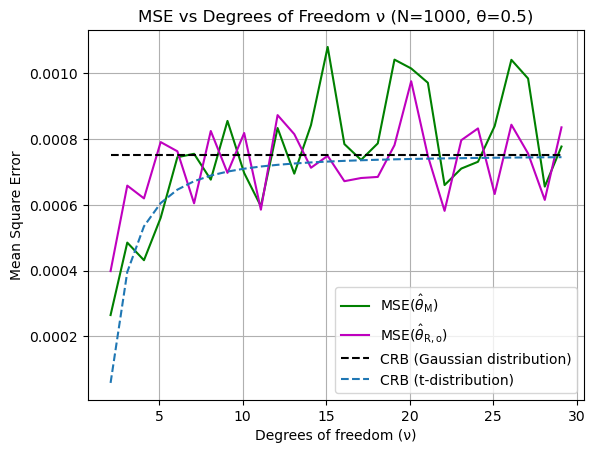

In [161]:
# Visualization as a function of v
plt.plot(list_v,mean_square_error_list_m_v,color='g',label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{M}})$")
plt.plot(list_v,mean_square_error_list_r_one_step_exact,color="m",label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{R,o}})$")
plt.plot(list_v, np.full_like(list_v, (1-theta**2)/N), '--k', label="CRB (Gaussian distribution)") 
plt.plot(list_v, CRB_Student_list_v, '--', label="CRB (t-distribution)") 
plt.xlabel("Degrees of freedom (ν)")
plt.ylabel("Mean Square Error")
plt.title(f"MSE vs Degrees of Freedom ν (N={N}, θ={theta})")
plt.legend()
plt.grid(True)
plt.show()

In [163]:
# Simulations for θ with R one-step exact estimator
N = 1000
theta = 0.5
sigma = 1
v = 3
list_theta = np.arange(0.01, 0.99, 0.01)
CRB_list_theta = [(1-th**2)/N for th in list_theta]
CRB_Student_list_theta = [compute_CRB(th,N,v) for th in list_theta ]
mean_square_error_list_m_theta = []
mean_square_error_list_r_one_step_exact_theta = []

for th in tqdm(list_theta):
    mean_square_error_list_m_theta.append(mse_m_estimator(th,N,sigma,v,c=0.798,loss_function=huber,nb_est=100))
    mean_square_error_list_r_one_step_exact_theta.append(mse_r_estimator_one_step_exact(th, N, sigma, v, nb_est=100))


  0%|          | 0/98 [00:00<?, ?it/s]C:\Users\inech\AppData\Local\Temp\ipykernel_74020\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)
100%|██████████| 98/98 [29:12<00:00, 17.88s/it]


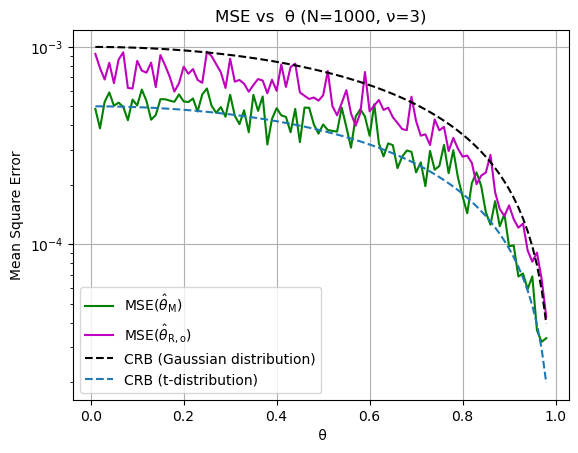

In [164]:
# Visualization as a function of θ
plt.plot(list_theta,mean_square_error_list_m_theta,color="g",label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{M}})$")
plt.plot(list_theta,mean_square_error_list_r_one_step_exact_theta,color="m",label=r"$\mathrm{MSE}(\hat{\theta}_{\mathrm{R,o}})$")
plt.plot(list_theta, CRB_list_theta, '--k', label="CRB (Gaussian distribution)")
plt.plot(list_theta, CRB_Student_list_theta, '--', label="CRB (t-distribution)") 
plt.xlabel(" θ")
plt.yscale("log")
plt.ylabel("Mean Square Error")
plt.title(f"MSE vs  θ (N={N}, ν={v})")
plt.legend()
plt.grid(True)
plt.show()

MSE of the R one-step estimator

In [ ]:
# Compute the MSE of the R one-step estimator for three values
N = 1000
theta = 0.5
sigma = 1
v=3
N_for_r_estimator = [2500, 5000, 10000]
mse_r_one_step_points = []
for n_r in tqdm(N_for_r_estimator, desc="Compute MSE for R-estimator"):
    mse_r_one_step_points.append(mse_r_estimator_one_step(theta, n_r, sigma, v, nb_est=nb_est))

Compute MSE for R-estimator: 100%|██████████| 3/3 [1:41:16<00:00, 2025.48s/it]


In [40]:
print(f"N = {N_for_r_estimator[0]}\n")
print("MSE of the R-estimator",mse_r_one_step_points[0])
print("MSE of the M-estimator",mse_m_estimator(theta,N_for_r_estimator[0],sigma,v,0.798,huber,nb_est))
print("MSE of the Newton estimator",mse_newton(theta,N_for_r_estimator[0],sigma,v,nb_est))
print("MSE of the ML estimator",mse_ml(theta,N_for_r_estimator[0],sigma,v,nb_est))
print("\n")

print(f"N = {N_for_r_estimator[1]}\n")

print("MSE of the R-estimator",mse_r_one_step_points[1])
print("MSE of the M-estimator",mse_m_estimator(theta,N_for_r_estimator[1],sigma,v,0.798,huber,nb_est))
print("MSE of the Newton estimator",mse_newton(theta,N_for_r_estimator[1],sigma,v,nb_est))
print("MSE of the ML estimator",mse_ml(theta,N_for_r_estimator[1],sigma,v,nb_est))
print("\n")

print(f"N = {N_for_r_estimator[2]}\n")

print("MSE of the R-estimator",mse_r_one_step_points[2])
print("MSE of the M-estimator",mse_m_estimator(theta,N_for_r_estimator[2],sigma,v,0.798,huber,nb_est))
print("MSE of the Newton estimator",mse_newton(theta,N_for_r_estimator[2],sigma,v,nb_est))
print("MSE of the ML estimator",mse_ml(theta,N_for_r_estimator[2],sigma,v,nb_est))

N = 2500

MSE of the R-estimator 0.00025404219966929277


C:\Users\inech\AppData\Local\Temp\ipykernel_74020\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


MSE of the M-estimator 0.00015792852695457188
MSE of the Newton estimator 0.0001712636869261873
MSE of the ML estimator 0.00019498414516282272


N = 5000

MSE of the R-estimator 0.0001065099237615323
MSE of the M-estimator 8.412078288339845e-05
MSE of the Newton estimator 8.626884789081284e-05
MSE of the ML estimator 0.00019832811495912146


N = 10000

MSE of the R-estimator 5.173496994415283e-05
MSE of the M-estimator 3.303849761118791e-05
MSE of the Newton estimator 3.561188586289502e-05
MSE of the ML estimator 7.79008102347386e-05


In [ ]:
# Compute the MSE of the R one-step estimator exact for three values
N = 1000
theta = 0.5
sigma = 1
v=3
theta_for_r_estimator = [0.1, 0.5, 0.9]
mse_r_one_step_points_t = []
for t_r in tqdm(theta_for_r_estimator, desc="Compute MSE for R-estimator"):
    mse_r_one_step_points_t.append(mse_r_estimator_one_step(t_r, N, sigma, v, nb_est=5000))

Compute MSE for R-estimator: 100%|██████████| 3/3 [2:17:31<00:00, 2750.46s/it]


In [74]:
print(f"theta = {theta_for_r_estimator[0]}\n")
print("MSE of the R-estimator",mse_r_one_step_points_t[0])
print("MSE of the M-estimator",mse_m_estimator(theta_for_r_estimator[0], N, sigma, v, 0.798, huber, nb_est))
print("MSE of the Newton estimator",mse_newton(theta_for_r_estimator[0], N, sigma, v, nb_est))
print("MSE of the ML estimator",mse_ml(theta_for_r_estimator[0], N, sigma, v, nb_est))
print("\n")

print(f"theta = {theta_for_r_estimator[1]}\n")
print("MSE of the R-estimator",mse_r_one_step_points_t[1])
print("MSE of the M-estimator",mse_m_estimator(theta_for_r_estimator[1], N, sigma, v, 0.798, huber, nb_est))
print("MSE of the Newton estimator",mse_newton(theta_for_r_estimator[1], N, sigma, v, nb_est))
print("MSE of the ML estimator",mse_ml(theta_for_r_estimator[1], N, sigma, v, nb_est))
print("\n")

print(f"theta = {theta_for_r_estimator[2]}\n")
print("MSE of the R-estimator",mse_r_one_step_points_t[2])
print("MSE of the M-estimator",mse_m_estimator(theta_for_r_estimator[2], N, sigma, v, 0.798, huber, nb_est))
print("MSE of the Newton estimator",mse_newton(theta_for_r_estimator[2], N, sigma, v, nb_est))
print("MSE of the ML estimator",mse_ml(theta_for_r_estimator[2], N, sigma, v, nb_est))

theta = 0.1

MSE of the R-estimator 0.0716855166794766
MSE of the M-estimator 0.0005029300446712359


C:\Users\inech\AppData\Local\Temp\ipykernel_74020\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


MSE of the Newton estimator 0.0004820375335947828
MSE of the ML estimator 0.0009949066823455098


theta = 0.5

MSE of the R-estimator 0.0007372509075344853
MSE of the M-estimator 0.00045521219999788135
MSE of the Newton estimator 0.00032698903791474943
MSE of the ML estimator 0.0007702324389662286


theta = 0.9

MSE of the R-estimator 0.004695728487322727
MSE of the M-estimator 8.429369432620092e-05
MSE of the Newton estimator 0.0001114081723330406
MSE of the ML estimator 0.00017713819562157357


In [ ]:
# Compute the MSE of the R one-step estimator exact for three values
N = 1000
theta = 0.5
sigma = 1
v=3
v_for_r_estimator = [3, 10, 29.1]
mse_r_one_step_points_v2 = []
for v_r in tqdm(v_for_r_estimator, desc="Compute MSE for R-estimator"):
    mse_r_one_step_points_v2.append(mse_r_estimator_one_step(theta, N, sigma, v_r, nb_est=5000))

Compute MSE for R-estimator: 100%|██████████| 3/3 [2:19:29<00:00, 2789.71s/it]


In [48]:
print(f"v = {v_for_r_estimator[0]}\n")
print("MSE of the R-estimator",mse_r_one_step_points_v2[0])
print("MSE of the M-estimator",mse_m_estimator(theta, N, sigma, v_for_r_estimator[0], 0.798, huber, nb_est=5000))
print("MSE of the Newton estimator",mse_newton(theta, N, sigma, v_for_r_estimator[0], nb_est=5000))
print("MSE of the ML estimator",mse_ml(theta, N, sigma, v_for_r_estimator[0], nb_est=5000))
print("\n")

print(f"v = {v_for_r_estimator[1]}\n")
print("MSE of the R-estimator",mse_r_one_step_points_v2[1])
print("MSE of the M-estimator",mse_m_estimator(theta, N, sigma, v_for_r_estimator[1], 0.798, huber, nb_est=5000))
print("MSE of the Newton estimator",mse_newton(theta, N, sigma, v_for_r_estimator[1], nb_est=5000))
print("MSE of the ML estimator",mse_ml(theta, N, sigma, v_for_r_estimator[1], nb_est=5000))
print("\n")

print(f"v = {v_for_r_estimator[2]}\n")
print("MSE of the R-estimator",mse_r_one_step_points_v2[2])
print("MSE of the M-estimator",mse_m_estimator(theta, N, sigma, v_for_r_estimator[2], 0.798, huber, nb_est=5000))
print("MSE of the Newton estimator",mse_newton(theta, N, sigma, v_for_r_estimator[2], nb_est=5000))
print("MSE of the ML estimator",mse_ml(theta, N, sigma, v_for_r_estimator[2], nb_est=5000))

v = 3

MSE of the R-estimator 0.0025739892453783006


C:\Users\inech\AppData\Local\Temp\ipykernel_74020\2786061511.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system,x0=theta,args=(X,c,loss_function),maxfev=2000)


MSE of the M-estimator 0.00040667391258179765
MSE of the Newton estimator 0.0004237606969030667
MSE of the ML estimator 0.0007514796845762802


v = 10

MSE of the R-estimator 0.0007907979911401554
MSE of the M-estimator 0.0007462980946771596
MSE of the Newton estimator 0.0006910803182624133
MSE of the ML estimator 0.0007623040541597231


v = 29.1

MSE of the R-estimator 0.0009873918689722902
MSE of the M-estimator 0.0008520185418146677
MSE of the Newton estimator 0.000754238483201838
MSE of the ML estimator 0.000774376794963939
